In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
import pandas as pd
%matplotlib inline
import seaborn as sns

In [3]:
acts_data_dtypes = {'ddl_case_id':'str','act':pd.np.float64,'section':'object','bailable_ipc':'object','number_sections_':'object','criminal':'object'}
acts_data = pd.read_csv('/kaggle/input/courts/acts_sections/acts_sections.csv',dtype=acts_data_dtypes);

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [4]:
judges_data_dtypes = {'ddl_judge_id':'float64','state_code':'str','dist_code':'str','court_no':'str','judge_position':'str','female_judge':'object','start_date':'object','end_date':'object'}
judges_data = pd.read_csv('/kaggle/input/courts/judges_clean/judges_clean.csv',engine='c',dtype = judges_data_dtypes)

In [5]:
cases_dtypes = {
'date_of_decision':'object',
'date_next_list' :'object',
'date_last_list':'object',
'ddl_case_id':'object',
'cino':'object',
'disp_name':'object',
'type_name':'object',
'date_of_filing':'object',
'purpose_name' :'object',
'date_first_list':'object',
'judge_position' :'object',
'court_no':'object',
'female_defendant':'object',
'female_adv_def':'object',
'female_petitioner':'object',
'dist_code':'object',
'female_adv_pet':'object',
'year':'object',
'state_code':'object'
}
all_cases = {}
for i in range(5):
    path = '/kaggle/input/courts/cases/cases/cases_201' + str(i) + '.csv'
    all_cases[i] = pd.read_csv(path,engine='c',error_bad_lines=False,dtype=cases_dtypes)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
judges_data.head()

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date
0,1.0,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014
1,2.0,1,1,1,chief judicial magistrate,0 nonfemale,31-10-2013,20-02-2014
2,3.0,1,1,1,chief judicial magistrate,0 nonfemale,21-02-2014,31-05-2016
3,4.0,1,1,1,chief judicial magistrate,0 nonfemale,01-06-2016,06-06-2016
4,5.0,1,1,1,chief judicial magistrate,0 nonfemale,06-06-2016,07-07-2018


In [ ]:
acts_data.head()

In [ ]:
all_cases[2].head()

In [7]:
# FOR CASES DATA
for i in range(5):
    dateofdecision = pd.to_datetime(all_cases[i]['date_of_decision'], format = '%Y-%m-%d',errors = 'coerce');
    dateoffiling = pd.to_datetime(all_cases[i]['date_of_filing'], format = '%Y-%m-%d',errors = 'coerce')
    dateofnexthearing = pd.to_datetime(all_cases[i]['date_next_list'], format = '%Y-%m-%d',errors = 'coerce')
    all_cases[i]['Time_to_Decision'] = (dateofdecision - dateoffiling).dt.days

In [8]:
for j in range(5):
    for i in range(all_cases[j]['Time_to_Decision'].shape[0]):
        if(pd.isna(all_cases[j]['Time_to_Decision'][i])):
            try:
                all_cases[j]['Time_to_Decision'][i] = (all_cases[j]['date_next_list'][i] - all_cases[j]['date_of_filing'][i]).dt.days
            except:
                all_cases[j]['Time_to_Decision'][i] = np.nan

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [10]:
for i in range(5):
    all_cases[i]['date_of_decision']=all_cases[i]['date_of_decision'].dt.strftime('%Y-%m-%d')
    all_cases[i]['date_of_filing']=all_cases[i]['date_of_filing'].dt.strftime('%Y-%m-%d')
    all_cases[i]['date_next_list']=all_cases[i]['date_next_list'].dt.strftime('%Y-%m-%d')

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
print(all_cases[i]['Time_to_Decision'].shape
# for i in range(all_cases[i]['Time_to_Decision'].shape[0]):
#     if(math.isnan(all_cases[i]['Time_to_Decision'][i])):
#         print("ye");
#         break;

In [18]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder

X = all_cases[0].copy()
X = X.drop(['date_of_decision','date_of_filing','date_next_list'],axis=1)
y = X.pop('Time_to_Decision')

# Identifying categorical columns
s = (X.dtypes == 'object')
object_cols = list(s[s].index)

# Ordinal encoding categorical columns
ordinal_encoder = OrdinalEncoder()
X[object_cols] = ordinal_encoder.fit_transform(X[object_cols])

# Cleaning of all infinite or nan values
y.replace([np.inf, -np.inf], np.nan, inplace=True)
mean_y = y.mean()
y.fillna(value=mean_y,inplace=True)

X.replace([np.inf, -np.inf], np.nan, inplace=True)
for columns in X:
    try:
      mean = X[columns].mean()
      X[columns].fillna(value = mean,inplace = True)
    except:
        X[columns].fillna(0)

# Label encoding for categoricals
for colname in X.select_dtypes(["object","category"]):
    X[colname], _ = X[colname].factorize()

# identifying distinct features columns for mutual_info_regression
discrete_features = X.dtypes == int


In [11]:
# calculate mutual inclusion scores
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    print("done")
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
mi_scores = make_mi_scores(X, y, discrete_features)
print(mi_scores)  # show a few features with their MI scores

In [13]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)

In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
plt.title("Mutual Info Score for 2010 cases")

Text(0.5, 1.0, 'Mutual Info Score for 2011 cases')

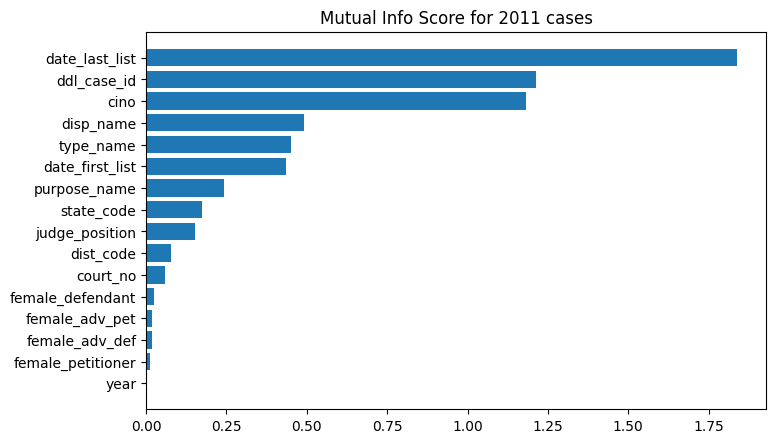

In [14]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
plt.title("Mutual Info Score for 2011 cases")

In [ ]:
# JUDGES DATA VISULISATION

#calculate tenure of judges
datestart = pd.to_datetime(judges_data['start_date'], format = '%d-%m-%Y',errors = 'coerce');
dateend = pd.to_datetime(judges_data['end_date'], format = '%d-%m-%Y',errors = 'coerce');
judges_data['tenure'] = (dateend - datestart).dt.days

In [ ]:
plt.figure(dpi=100, figsize=(20, 20))
sns.scatterplot(hue='state_code',y='tenure',x = 'female_judge',data=judges_data)

In [ ]:
sns.histplot(judges_data,x='female_judge',hue='state_code')

In [ ]:
# compare judges tenure with their position
plt.figure(dpi=100,figsize = (20,20))
# plt.xticks(rotation=45)
# plt.rc('xtick', labelsize=7)
sns.histplot(judges_data,hue='judge_position',y='tenure',x='state_code',)

In [ ]:
# T-1 states (pink) => Chandigarh , Telangana , Goa , Delhi
# T-2 states (brown) => Assam , Bihar , Himachal , Jharkhand
# T-3 states (orange,red) => Andhra , Karnataka , Kerela 
# T-4 states(blue) => Chattisgarh , Gujarat , Haryana , Mizoram
# Surprising T-1 states have less population but more judges 
# Judges in T-3 states tend to have a longer tenure
# Discrepency in the number of male and female judges is more in T-1 states 
# T- 4 states dont have much clarity but their judges have longer tenure

In [ ]:
# Lets , try to see the relation with judges / crime in each state
n = len(pd.unique(judges_data['state_code']))
list = []
for i in range(1,n+1):
    # how many judges are there in a state 'i' ??
    x = len(judges_data[judges_data['state_code'] == str(i)])
    # how many cases are there in state 'i'
    num_case = 0;
    for j in range(5):
        num_case += len(all_cases[j][all_cases[j]['state_code'] == str(i//10) + str(i%10)])
    print(i,x,num_case)
    list.append({'StateCode':i,'num_judges':x,'num_cases':num_case})

In [ ]:
df = pd.DataFrame(list)
df.head()

In [ ]:
df['judge_per_case'] = df['num_cases'] // df['num_judges']
print(df)

In [ ]:
#States with more cases / judge => Haryana , Karnataka ,Kerala , Chandigarh , Punjab 
#States with less => Jharkhand ( A densely populated state , so it either means that reporting of cases is not proper there or there are less crimes happening in jharkhand ) , Jammu and Kashmir (same reasoning as Jharkhand) , Manipur , Mizoram and Sikkim

In [ ]:
sns.scatterplot(data=df,x='StateCode',y='judge_per_case',hue='StateCode')

In [ ]:
# Now , lets work with classifier predicting judge_tenure
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
df = judges_data.copy()[['state_code','tenure','start_date','judge_position']]

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

s = (df.dtypes == 'object')
object_cols = list(s[s].index)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
for columns in df:
    try:
      mean = df[columns].mean()
      df[columns].fillna(value = mean,inplace = True)
    except:
        df[columns].fillna(0)

# Label encoding for categoricals
for colname in df.select_dtypes(["object","category"]):
    df[colname], _ = df[colname].factorize()

In [ ]:
df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

In [ ]:
df_valid.head()

In [ ]:
df_train.head()

In [ ]:
X_train = df_train.drop('judge_position', axis=1)
X_valid = df_valid.drop('judge_position', axis=1)
y_train = df_train['judge_position']
y_valid = df_valid['judge_position']

In [ ]:
X_train = np.asarray(X_train).astype(np.float32)
X_valid = np.asarray(X_valid).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32) 
y_valid = np.asarray(y_valid).astype(np.float32) 

In [ ]:
X_train[0]
y_train[0]

In [ ]:
n = len(pd.unique(df['judge_position']))
print(n)

In [ ]:
from tensorflow.keras import callbacks
model = keras.Sequential([
    layers.Dense(16,activation='relu',input_shape=[3]),
    layers.Dense(4,activation='relu'),
    layers.Dense(n,activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # measures distance in probabilities
    metrics=['accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=1000, # we have an early stopping callback,
    callbacks=[early_stopping],
    verbose=0
)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()

In [ ]:
history_df.loc[5:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
label = model.predict([[ 15., 176., 652.]])
print(label)